# Simple IST model

$$D_{n+1}=D_n+\lambda(1-D_n)^\beta$$
$$\Delta R_n^{(D)}=\kappa D_n$$

Where
- $\kappa$ is a proportionality constant, can be set to 1
- $D_n\in[0,1]$ (0 = no damage, 1 = failure)
- $\beta \geq 1$ (=1 Miner/Palmgren)
- $\lambda>0$ effective damage rate $[t^{-1}]$

Optional: Arrhenius–Coffin–Manson
$$\lambda = A(|\alpha_{Cu}-\alpha_{lam}|(T_\text{set}-T_\text{ref}))^m \exp{\Bigg(\frac{-Q}{R_gT_\text{set}}\Bigg)}$$

In [ ]:
import torch
import torch.nn as nn
import torch.func as F
import matplotlib.pyplot as plt
import numpy as np

In [57]:
class DuctileIST(nn.Module):
    
    def __init__(self, L, eps=1e-12,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.L = L
        self.kappa=1
        self.eps = eps
        
    def forward(self, model_out: torch.Tensor):
        # lam, beta, kappa have shape [batch, 1]  (broadcastable)
        
        lam = 1e-3*torch.relu(model_out[:,0].unsqueeze(-1))      # [bs, 1]
        beta = 1.0 + 10.0*torch.relu(model_out[:,1].unsqueeze(-1))     # [bs, 1]
        D   = torch.zeros_like(lam, device=model_out.get_device()) # [bs, 1] D₀ = 0
        
        out = [D]                       # append the first one in zero

        for _ in range(self.L-1):
            one_minus_D = torch.clamp(1.0 - D, min=self.eps)
            update = lam * torch.exp(beta * torch.log(one_minus_D)) # implemented a^x = exp(x log(a))
            D = torch.clamp(D + update, max=1.0 - self.eps)
            out.append(self.kappa * D)
            
        return torch.nan_to_num(torch.cat(out, dim=-1))   # shape [batch, L]

torch.Size([10, 1])
torch.Size([10, 1])


C:\Users\ScipioneFrancesco\AppData\Local\Temp\ipykernel_25068\2273248544.py:46: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3641.)
  ax1.plot(deltaR_0[i].T, color=color, linewidth=2, alpha=0.8)


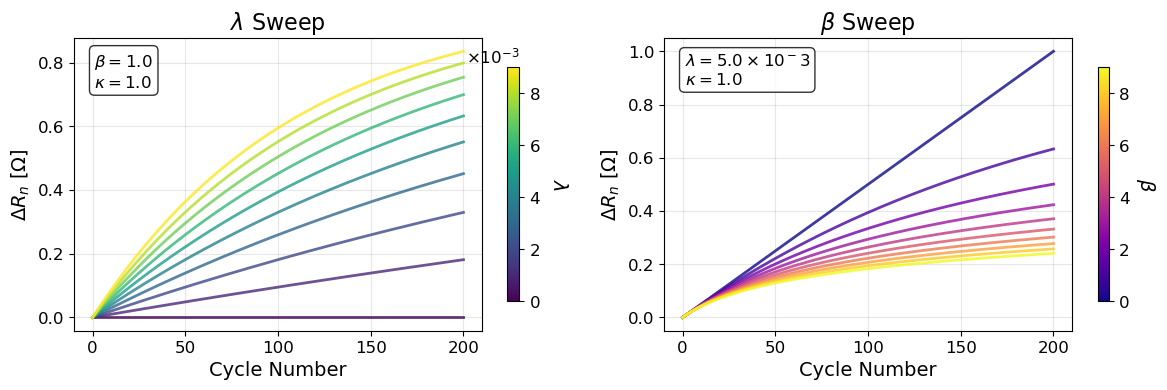

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# import numpy as np
# from matplotlib.ticker import ScalarFormatter

# def create_publication_plot():
#     # Parameters
#     L = 200
    
#     # Lambda sweep parameters
#     lam_sweep = torch.arange(10).unsqueeze(-1) / 1000
#     beta_0 = torch.tensor(1.0).expand_as(lam_sweep)
#     kappa_0 = torch.tensor(1.0).expand_as(lam_sweep)
    
#     # Beta sweep parameters
#     beta_sweep = torch.arange(10).unsqueeze(-1)
#     lam_1 = torch.tensor(0.005).expand_as(beta_sweep)
#     kappa_1 = torch.tensor(1.0).expand_as(beta_sweep)
    
#     # Generate data
#     deltaR_0 = ISTRollout().forward(lam_sweep, beta_0, kappa_0, L)
#     deltaR_1 = ISTRollout().forward(lam_1, beta_sweep, kappa_1, L)
    
#     # Create figure with publication quality settings
#     plt.rcParams.update({
#         'font.size': 12,
#         'axes.labelsize': 14,
#         'axes.titlesize': 16,
#         'xtick.labelsize': 12,
#         'ytick.labelsize': 12,
#         'legend.fontsize': 11,
#         'figure.titlesize': 18
#     })
    
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
#     # Left subplot: Lambda sweep
#     # Color mapping for lambda values
#     lam_values = lam_sweep.numpy().flatten()
#     norm1 = colors.Normalize(vmin=lam_values.min(), vmax=lam_values.max())
#     cmap1 = cm.viridis
    
#     for i, lam_val in enumerate(lam_values):
#         color = cmap1(norm1(lam_val))
#         ax1.plot(deltaR_0[i].T, color=color, linewidth=2, alpha=0.8)
    
#     ax1.set_xlabel('Cycle Number')
#     ax1.set_ylabel(r'$\Delta R_n$ [Ω]')
#     ax1.set_title(r'$\lambda$ Sweep')
#     ax1.grid(True, alpha=0.3)
    
#     # Add text box with fixed parameters for left plot
#     ax1.text(0.05, 0.95, rf'$\beta=${beta_0[0][0]}' + '\n' + rf'$\kappa = {kappa_0[0][0]}$', 
#              transform=ax1.transAxes, verticalalignment='top',
#              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
#     # Add colorbar for lambda sweep with scientific notation
#     sm1 = cm.ScalarMappable(cmap=cmap1, norm=norm1)
#     sm1.set_array([])
#     cbar1 = plt.colorbar(sm1, ax=ax1, shrink=0.8, aspect=20)
#     cbar1.set_label(r'$\lambda$', rotation=270, labelpad=20)
    
#     # Format colorbar ticks in scientific notation
#     formatter = ScalarFormatter(useMathText=True)
#     formatter.set_scientific(True)
#     formatter.set_powerlimits((-1, 1))
#     cbar1.ax.yaxis.set_major_formatter(formatter)
    
#     # Right subplot: Beta sweep
#     # Color mapping for beta values
#     beta_values = beta_sweep.numpy().flatten()
#     norm2 = colors.Normalize(vmin=beta_values.min(), vmax=beta_values.max())
#     cmap2 = cm.plasma
    
#     for i, beta_val in enumerate(beta_values):
#         color = cmap2(norm2(beta_val))
#         ax2.plot(deltaR_1[i].T, color=color, linewidth=2, alpha=0.8)
    
#     ax2.set_xlabel('Cycle Number')
#     ax2.set_ylabel(r'$\Delta R_n$ [Ω]')
#     ax2.set_title(r'$\beta$ Sweep')
#     ax2.grid(True, alpha=0.3)
    
#     # Add text box with fixed parameters for right plot
#     ax2.text(0.05, 0.95, rf'$\lambda={lam_1[0][0]*1E3} \times 10^{-3}$' + '\n' + rf'$\kappa = {kappa_1[0][0]}$', 
#              transform=ax2.transAxes, verticalalignment='top',
#              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
#     # Add colorbar for beta sweep
#     sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
#     sm2.set_array([])
#     cbar2 = plt.colorbar(sm2, ax=ax2, shrink=0.8, aspect=20)
#     cbar2.set_label(r'$\beta$', rotation=270, labelpad=20)
    
#     # # Overall figure title
#     # fig.suptitle('IST Model: Resistance Change vs. Damage Parameters', 
#     #              fontsize=18, y=0.98)
    
#     # Adjust layout to prevent overlap
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.90)
    
#     # Show the plot
#     plt.show()

# # Call the function
# create_publication_plot()


## Fracture Term
$$
F_{n+1}=(1+\mu g_n)F_n+\epsilon g_n
$$

- $F_n\in(0,1]$
- $\mu>0$ pole gain
- $g_n(n,n_c,w) = \frac{1}{1+\exp{(-(n-n_c/2))}}$
    - $n_c$ is the pole coordinate
    - $n$ is the cycle, when $n=n_c$, $g_n\to 1$


$$\Delta R_n^{(F)}=\kappa_f F_n$$

with the proportionality constant $\kappa_f$.


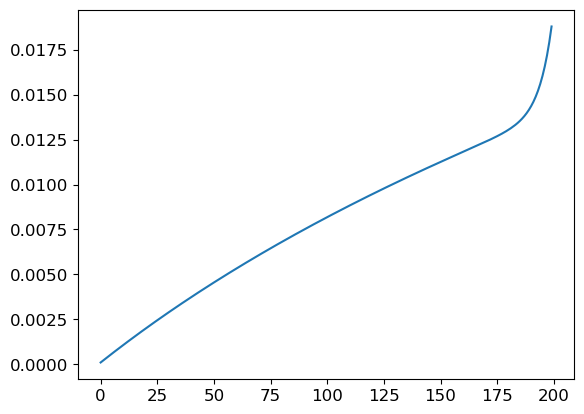

In [ ]:
class FractureIST(nn.Module):
    def __init__(self, eps=1e-12):
        super().__init__()
        self.eps = eps

    def forward(self, lam, beta, k_d,
                      mu, k_f,
                      n_c, w_t,   # or  D_c, w_D
                      N, eps=None):
        eps = eps or self.eps
        batch = lam.size(0)

        # initialise states
        D = lam.new_zeros(batch)
        F = lam.new_full((batch,), eps)      # tiny seed
        out = []

        for n in range(int(N)):
            # ---- ductile channel -------------------------------------------------
            one_minus_D = torch.clamp(1. - D, min=eps)
            D = D + lam * one_minus_D.pow(beta)
            # ---------------------------------------------------------------------

            # ---- gate (time–trigger version) ------------------------------------
            g = torch.sigmoid((n - n_c) / w_t)     # shape [batch]
            # ---------------------------------------------------------------------

            # ---- fracture unstable pole -----------------------------------------
            F = (1 + mu * g) * F + eps * g         # eq. (B)
            F = torch.clamp(F, 0., 1. - eps)       # stay in domain
            # ---------------------------------------------------------------------

            deltaR = k_d * D + k_f * F             # eq. (E)
            out.append(deltaR)

        return torch.stack(out, dim=-1)            # [B, N]


In [53]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from matplotlib.ticker import ScalarFormatter

def plot_parameter_sweeps(model_class, param_config, fixed_params=None, num_sweeps=10):
    """
    Create publication-ready parameter sweep plots for FractureIST and DuctileIST classes.
    Uses batch dimension to perform parameter sweeps efficiently.
    
    Parameters:
    -----------
    model_class : nn.Module class
        The neural network class to plot (FractureIST or DuctileIST)
    param_config : dict
        Dictionary with parameters to sweep: {"param_name": {"base": value, "span": (min, max)}}
    fixed_params : dict, optional
        Dictionary with fixed parameters to pass to the model
    num_sweeps : int, default=10
        Number of sweep points per parameter
    """
    
    # LaTeX symbol mapping
    LATEX_MAPPING = {
        'lam': r'$\lambda$',
        'beta': r'$\beta$', 
        'kappa': r'$\kappa$',
        'mu': r'$\mu$',
        'k_d': r'$k_d$',
        'k_f': r'$k_f$',
        'n_c': r'$n_c$',
        'w_t': r'$w_t$',
        'eps': r'$\epsilon$',
        'L': r'$L$',
        'N': r'$N$'
    }
    
    # Colormap list for different parameters
    COLORMAPS = [cm.viridis, cm.plasma, cm.inferno, cm.cividis, cm.magma, cm.turbo]
    
    if fixed_params is None:
        fixed_params = {}
    
    # Set publication quality settings
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 11,
        'figure.titlesize': 18
    })
    
    # Initialize model - handle constructor parameters
    if model_class.__name__ == 'DuctileIST':
        # DuctileIST requires L parameter in constructor
        L = fixed_params.get('L', 200)  # default L=200
        model = model_class(L=L)
    else:
        model = model_class()
    
    # Determine model type
    is_ductile = isinstance(model, DuctileIST)
    is_fracture = isinstance(model, FractureIST)
    
    if not (is_ductile or is_fracture):
        raise ValueError(f"Unsupported model class: {model_class.__name__}")
    
    # Process each parameter - create separate figure for each
    for idx, (param_name, config) in enumerate(param_config.items()):
        
        # Validate parameter for model type
        if is_ductile and param_name not in ['lam', 'beta']:
            print(f"Warning: DuctileIST only supports 'lam' and 'beta' parameters. Skipping '{param_name}'")
            continue
            
        # Create new figure for this parameter
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        cmap = COLORMAPS[idx % len(COLORMAPS)]
        
        # Create sweep values
        span_min, span_max = config["span"]
        sweep_values = torch.linspace(span_min, span_max, num_sweeps)
        
        if is_ductile:
            # For DuctileIST: create model_out tensor [batch, 2]
            # Handle parameter transformations that happen inside DuctileIST
            
            # Get base values for both parameters
            lam_base = param_config.get('lam', {}).get('base', 0.005)
            beta_base = param_config.get('beta', {}).get('base', 1.0)
            
            if param_name == 'lam':
                # Sweep lam, fix beta
                # Note: DuctileIST applies 1e-3 scaling and relu, so we need raw values
                lam_raw = sweep_values / 1e-3  # reverse the 1e-3 scaling
                beta_raw = (beta_base - 1.0) / 10.0  # reverse the 1.0 + 10.0 scaling
                model_out = torch.stack([lam_raw, torch.full_like(lam_raw, beta_raw)], dim=1)
            else:  # param_name == 'beta'
                # Sweep beta, fix lam
                lam_raw = lam_base / 1e-3  # reverse the 1e-3 scaling
                beta_raw = (sweep_values - 1.0) / 10.0  # reverse the 1.0 + 10.0 scaling
                model_out = torch.stack([torch.full_like(beta_raw, lam_raw), beta_raw], dim=1)
            
            # Run model
            output = model(model_out)  # [batch, L]
            
        elif is_fracture:
            # For FractureIST: prepare all parameters with batch dimension
            
            # Get all parameter base values
            all_params = {}
            for p in ['lam', 'beta', 'k_d', 'mu', 'k_f', 'n_c', 'w_t']:
                if p == param_name:
                    all_params[p] = sweep_values
                else:
                    base_val = param_config.get(p, {}).get('base', 
                                              fixed_params.get(p, 1.0))  # default to 1.0
                    all_params[p] = torch.full_like(sweep_values, base_val)
            
            # Handle N parameter (scalar, not batched)
            N = fixed_params.get('N', 200)
            
            # Run model
            output = model(
                lam=all_params['lam'],
                beta=all_params['beta'], 
                k_d=all_params['k_d'],
                mu=all_params['mu'],
                k_f=all_params['k_f'],
                n_c=all_params['n_c'],
                w_t=all_params['w_t'],
                N=N
            )  # [batch, N]
        
        # Plot results
        sweep_vals_np = sweep_values.numpy()
        norm = colors.Normalize(vmin=sweep_vals_np.min(), vmax=sweep_vals_np.max())
        
        for i, sweep_val in enumerate(sweep_vals_np):
            color = cmap(norm(sweep_val))
            ax.plot(output[i].detach().numpy(), color=color, linewidth=2, alpha=0.8)
        
        # Formatting
        ax.set_xlabel('Cycle Number')
        ax.set_ylabel(r'$\Delta R_n$ [Ω]')
        
        # Get LaTeX label for parameter
        param_latex = LATEX_MAPPING.get(param_name, param_name)
        ax.set_title(f'{param_latex} Sweep')
        ax.grid(True, alpha=0.3)
        
        # Add colorbar
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label(param_latex, rotation=270, labelpad=20)
        
        # Format colorbar for small values
        if abs(sweep_vals_np).max() < 0.01:
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-1, 1))
            cbar.ax.yaxis.set_major_formatter(formatter)
        
        # Create text box with fixed parameters
        text_lines = []
        
        # Add other sweep parameters at base values
        for other_param, other_config in param_config.items():
            if other_param != param_name:
                other_latex = LATEX_MAPPING.get(other_param, other_param)
                other_val = other_config["base"]
                if abs(other_val) < 0.01 and other_val != 0:
                    text_lines.append(f'{other_latex} = {other_val*1000:.1f} × 10⁻³')
                else:
                    text_lines.append(f'{other_latex} = {other_val}')
        
        # Add relevant fixed parameters (exclude cycle count parameters)
        exclude_params = {'L', 'N'}
        for fixed_param, fixed_val in fixed_params.items():
            if fixed_param not in exclude_params:
                fixed_latex = LATEX_MAPPING.get(fixed_param, fixed_param)
                display_val = fixed_val.item() if isinstance(fixed_val, torch.Tensor) else fixed_val
                if abs(display_val) < 0.01 and display_val != 0:
                    text_lines.append(f'{fixed_latex} = {display_val*1000:.1f} × 10⁻³')
                else:
                    text_lines.append(f'{fixed_latex} = {display_val}')
        
        if text_lines:
            text_content = '\n'.join(text_lines)
            ax.text(0.05, 0.95, text_content, 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Adjust layout and show
        plt.tight_layout()
        plt.show()

# Example usage for DuctileIST:
# param_config = {
#     "lam": {"base": 0.005, "span": (0.001, 0.01)},
#     "beta": {"base": 2.0, "span": (1.0, 5.0)}
# }
# fixed_params = {"L": 200}
# plot_parameter_sweeps(DuctileIST, param_config, fixed_params)

# Example usage for FractureIST:
# param_config = {
#     "lam": {"base": 0.0001, "span": (0.00005, 0.0002)},
#     "mu": {"base": 0.2, "span": (0.1, 0.3)}
# }
# fixed_params = {"N": 200, "beta": 50, "k_d": 1, "k_f": 10, "n_c": 100, "w_t": 5}
# plot_parameter_sweeps(FractureIST, param_config, fixed_params)


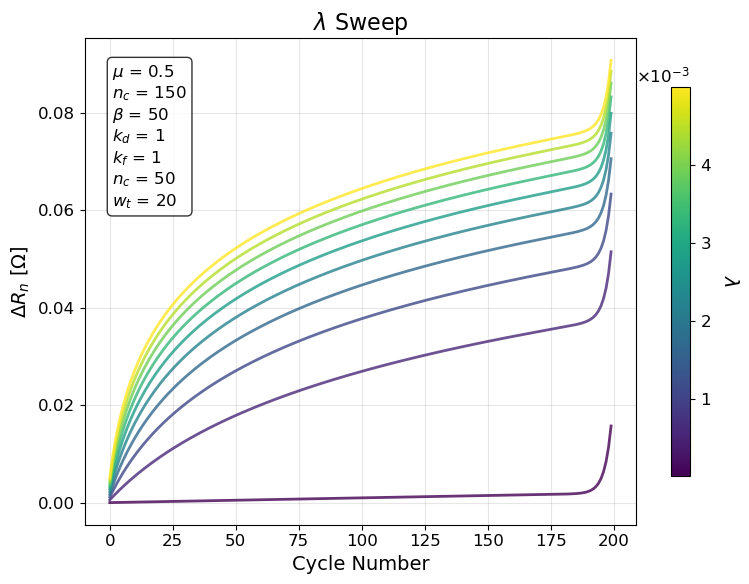

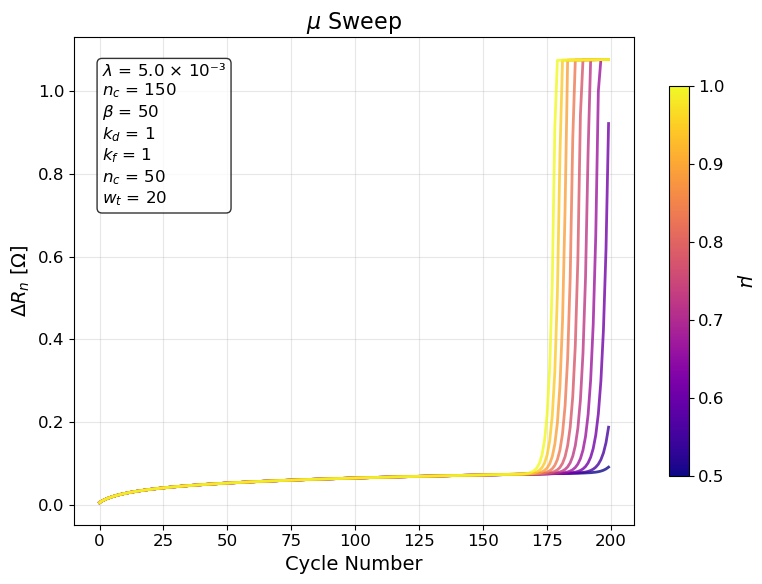

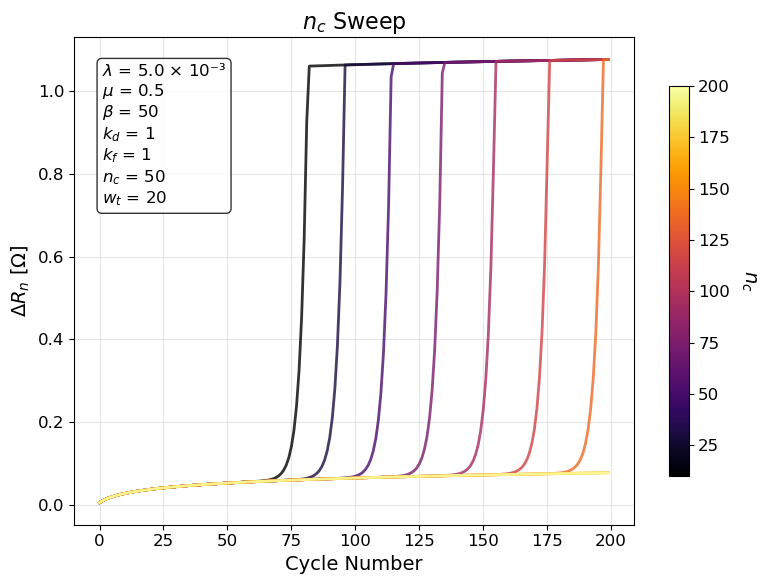

In [88]:
param_config = {
    "lam": {"base": 0.005, "span": (0.00001, 0.005)},
    "mu": {"base": 0.5, "span": (0.5, 1)},
    "n_c": {"base": 150, "span": (10, 200)}
}
fixed_params = {"N": 200, "beta": 50, "k_d": 1, "k_f": 1, "n_c": 50, "w_t": 20}
plot_parameter_sweeps(FractureIST, param_config, fixed_params)